# Digit Classifier 

In these notes we are going to build a digit classifier by two different approaches. 
The first one will be by contructing a neural network from scratch, i.e., creating all our own tools with Pytorch and Pythons classes, methods and functions.
In the second approach we will use that fast.ai already created all our previous functions and intermediate steps for the neural network. Therefore, we will go one by one trough them and replace them with fastai-builtin functions which will give us the same results but with less effort.

In [1]:
from fastai.vision.all import *
from fastbook import *

## Stochastic Gradient Descent (SGD)

Regardless of the way we proceed, in order to implement machine learning over our digit classifier we'll apply the SGD technique by following these rules:

1. **Initialize** the weights.
1. For each image, use these weights to **predict** the digit.
1. Based on these predictions, calculate how good the model is (its **loss**).
1. Calculate the **gradient**, which measures for each weight, how changing that weight would change the loss
1. **Step** (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and **repeat** the process.
1. Iterate until you decide to **stop** the training process (for instance, because the model is good enough or you don't want to wait any longer).

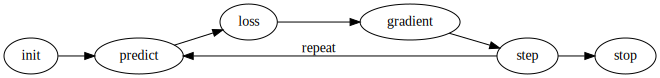

In [2]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

These seven steps, are the key to the training of all deep learning models (not only for this SGD method!). 
That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive.

## MNIST data

Before applying the SGD steps, we need the data. 
To do so we will begin simple, so instead of considering all digits from 0 to 9 of MNIST database we will concentrate on creating a program which distinguishes between 3s and 7s.

To do so we start by downloading the images for those two digits. Fastai helps us downloading the images already split into train and validation sets.

In [3]:
path = untar_data(URLs.MNIST_SAMPLE) # download images from URLs and unzip them into path
Path.BASE_PATH = path # renames path = "storage/data/..." as path = (".") but it isn't really necessary
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

Then we store them into variables after performing the following algorithm:
- For every image in the corresponding path, we open it and then convert it into a tensor in which each component represents a pixel of the original image. The white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image has 28 X 28 = 784 pixels.
- Then we fit all the tensors into a list. To convert that list of tensors into a tensor of rank-3 we use the stack method.
- Finally we normalize all the components to run from 0 to 1 by diving by they greatests number, 255.

In [4]:
test_3 = torch.stack([tensor(Image.open(o)) for o in (path/"train"/"3").ls()])
test_3 = test_3.float()/255
test_7 = torch.stack([tensor(Image.open(o)) for o in (path/"train"/"7").ls()])
test_7 = test_7.float()/255
valid_3 = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"3").ls()])
valid_3 = valid_3.float()/255
valid_7 = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"7").ls()])
valid_7 = valid_7.float()/255
test_3.shape,test_7.shape,valid_3.shape, valid_7.shape

(torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([1010, 28, 28]),
 torch.Size([1028, 28, 28]))

Finally, we rewrite our data in a more efficient way. We will concatenate all the independent variables (tensor of threes and tensor of sevens) and reshape each of the 28x28-dimensional tensors into a 784-dimensional vector (this is achieved by using the view function). 
For the dependent variables we'll create a vector which labels each three as 1 and each seven as 0.
Finally we organize all our dataset into a tuple.

In [5]:
# training set
train_x = torch.cat([test_3, test_7]).view(-1, 28*28)
train_y = tensor([1]*len(test_3) + [0]*len(test_7)).unsqueeze(1)
train_dataset = list(zip(train_x,train_y))
# validation set
valid_x = torch.cat([valid_3, valid_7]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3) + [0]*len(valid_7)).unsqueeze(1)
valid_dataset = list(zip(valid_x,valid_y))

## From scratch

Here we will build a neural network to classify digits from scratch just using Python and Pytorch and creating all the intermediate steps ourselves.

### 1. Initilize

The first step in the SGD method is to **initilize** the parameters randomly using torch.randn 

In [6]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
w = init_params((28*28,1))
b = init_params(1)

The requires_grad_ function is super important. Since we are using SGD, after all the process of learning we'll end up with a function over the parameters, i.e. $f(w,b)$ and we need its gradient in terms of w and b, $\left.\nabla_{w,b} f \right|_{w=w_{\text{ini}},b=b_{\text{ini}}}$, evaluated at the values they were initialized. This requires_grad function is keeping track of all the relevant information to carry on the process. It tells Pytorch that w and b will be independent variables of future functions and that, eventually, we'll need the gradient of them evaluated at the intialized value. Before continuing, lets revisit how this function is used in the simplest scenario and how to obtain the value of the gradient at the end.

In [7]:
# We begin defining a variable x (which has to be a tensor of floats) and ask for keeping track of the gradient 
# of any function applied over it. The requires_grad=True property is exactly refering to this characteristic.
x=tensor(2.).requires_grad_()
print(x)
# Now we define two functions to then compose them and see how gradients work also for compositions.
def f(x): return x**2
def g(x): return 5*x + 10
# We apply these functions over x and store it inside y. Now the function y(x) has the value and the property
# grad_fn which encodes the information of the gradient over the functions applied over x.
y= g(f(x))
print(y)
# Now we compute the gradient
y.backward()
# and obtain the gradient evaluated at the x point by the attribute grad over x
print(x.grad)

tensor(2., requires_grad=True)
tensor(30., grad_fn=<AddBackward0>)
tensor(20.)


### 2. Predict

With these initial values we define a function which just computes the product between w and a vector (carried by the @ symbol) and shift it by b. This defines our particular model and we use it over each of the vectors in test_x to **predict** the result.

In [8]:
def linear1(x): return x@w + b
predictions = linear1(train_x)
predictions

tensor([[-20.7097],
        [ -6.5004],
        [  2.6714],
        ...,
        [-13.9627],
        [ -2.2773],
        [-13.0499]], grad_fn=<AddBackward0>)

### 3. Loss

Then, let's define a function which meassures the distance between predictions and targets. This will be the **loss function** which takes the predictions of the model and their correct values (targets). 
The first step is to apply a sigmoid function on predictions which schrinks their values between 0 and 1. The where function computes how distant each prediction is from 1 if the correct value is 1, or from 0 if the correct value is 0. Then we compute the average of them with mean. (Is this the l1 norm?)

In [9]:
def loss_function(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### 4. Gradient

Now that we have our loss function we need to compute **gradients** so then we can use it to update the parameters. For it we need to specify how many data points we are going to use before updating the parameters. This set of points is called mini-batch and its size batch size. The best way to select it among all the test data is by doing it randomly. To do so one takes the training set, shuffles it randomly and just then split it into mini-batches. This procedure assures that for each epoch of the training process, the data from which we compute the gradients is different. The shuffling and mini-batch collection can be done with fastai's `DataLoader` class.

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=256)
valid_dataloader = DataLoader(valid_dataset, batch_size=256) # WHY DO WE DO THE SAME FOR THE VALIDATION SET?

To compute the gradients we put everything in a function. Its arguments are a mini-batch (x), its correct values (y) and the model (in our case the linear1 function). By applying the model over the mini-batch we obtain the predictions and then we compute the loss by using the loss function between the predictions and the correct values. Remember that loss(model(x),y) is a (composite) function of the parameters w and b and we are keeping track of its gradient at the initial values of w and b. With `backward` we are effectively computing this gradient.

In [11]:
def calculate_gradient(x, y, model):
    predictions = model(x)
    loss = loss_function(predictions, y)
    loss.backward()

### 5. 6. Step and Repeat

The remaining step is to use this gradient to **step** (or **update**) the parameters which is nothing but the training process. We group all the steps in a single function which does the following: For every mini-batch in train_dataloader it computes the gradient of it using model and then, for each parameter, w and b, it updates them by shifting them by the gradients times a learning rate that we have to fix. Notice that this very step is also a function over the parameters, so, in principle, when using backprop, this step would be also taken into account to compute the gradient. This would be undesired and so to avoid it we apply the shift to p.data instead to the whole p variables. Finally, we use grad.zero_() to reset the gradients of p to zero before changing to the next mini-batch, otherwise backprop would keep adding previous gradients to the result yet we want just the one computed for a single mini-batch at the time.

In [12]:
def train_epoch(model, learning_rate, parameters):
    for x,y in train_dataloader:
        calculate_gradient(x, y, model)
        for p in parameters:
            p.data -= p.grad*learning_rate
            p.grad.zero_()

### 7. Stop

Finally, in order to be able to decide when to **stop** training the machine, we need to compute the accuracy of our program using the validation set. To do so, we define a function which applies over a single mini-batch (of the validation set) and computes how many times we predict the correct result and takes its average. Finally we loop over all the batches with another function

In [13]:
def batch_accuracy(x, y):
    predictions = x.sigmoid()
    correct = (predictions>0.5) == y
    return correct.float().mean()

def validate_epoch(model):
    accuracy = [batch_accuracy(model(x), y) for x,y in valid_dataloader]
    return round(torch.stack(accuracy).mean().item(), 4)

With this validation functions we create our last function which trains the model for any desired epochs

In [14]:
def train_model(model, learning_rate, parameters, epochs):
    for i in range(epochs):
        train_epoch(model,learning_rate,parameters)
        print(validate_epoch(model), end=' ')

### Training the model

We begin by testing how good our model does without been trained, i.e. we initilize the parameters on some random values and we compute the accuracy on the validation set. This should be a number around 0.5 

In [15]:
w = init_params((28*28,1))
b = init_params(1)
validate_epoch(linear1)

0.5749

Now we train the model for 20 epochs and see how it learns

In [17]:
w = init_params((28*28,1))
b = init_params(1)
lr=1.
epochs=20
train_model(linear1,lr,(w,b),epochs)

0.5648 0.7914 0.9027 0.9305 0.9437 0.9525 0.9574 0.9618 0.9657 0.9677 0.9686 0.9701 0.9716 0.9726 0.974 0.975 0.976 0.976 0.976 0.9765 

## Using optimizers

Since SGD is such a general foundation, PyTorch provides some useful classes to make it easier to implement. For instance, nn.Linear does the same as our init_params and linear1 functions together.

In [18]:
linear_model = nn.Linear(28*28,1)
w,b = linear_model.parameters()

With it we can create an Optimizer class which has the update step as a function step(). Then we create an object of that class.

In [19]:
class BasicOptim:
    def __init__(self,params,lr): 
        self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [20]:
opt = BasicOptim(linear_model.parameters(), lr)

Then we can rewrite our training functions in a simpler form (we still need our calculate_gradient, loss_function  and validation accuracy functions!).

In [21]:
def train_epoch(model):
    for x,y in train_dataloader:
        calculate_gradient(x, y, model)
        opt.step()
        opt.zero_grad()
        
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

So now we can compute the same as before but with less work

In [23]:
train_model(linear_model, 20)

0.9775 0.9785 0.979 0.979 0.979 0.979 0.9795 0.98 0.98 0.98 0.9804 0.98 0.98 0.98 0.98 0.9804 0.9804 0.9804 0.9804 0.9804 

## Using Fastai

Now, if we notice that we don't have to reinvent the wheel, we can use full fastai functionalities. 
For instance, fastai has an `SGD` class which does the same as BasicOptim above (we could have just changed opt = SGD(linear_model.parameters(),lr)). 
Instead of train_model we can use fastai built-in-function Learner.fit. To do so we need a `DataLoaders` object (which is just a concatenation of our train_dataloader and valid_dataloader) and a `Learner`. The latter is created by passing in all the elements that we've created before: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [24]:
dataloaders = DataLoaders(train_dataloader,valid_dataloader)

learn = Learner(dataloaders, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=loss_function, metrics=batch_accuracy)

learn.fit(15, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.635921,0.496386,0.495584,00:00
1,0.232803,0.335271,0.649657,00:00
2,0.096188,0.161601,0.855250,00:00
3,0.049201,0.099221,0.915113,00:00
4,0.031444,0.072379,0.936703,00:00
5,0.024281,0.057924,0.953876,00:00
6,0.021078,0.049219,0.962218,00:00
7,0.019437,0.043645,0.965653,00:00
8,0.018443,0.039815,0.966143,00:00
9,0.017749,0.036999,0.969578,00:00
